## M1. Cleaning Robots
Room cleaning with random robot movement simulation

### Report
The model that simulates room cleaning has some limitations that make it difficult to completely clean the room under a time limit. All robots start at the same point in the upper left corner, so it is difficult for them to reach the opposite corner with random movements. Having random movement causes robots to choose points that cannot be reached when facing the wall of the room, wasting moves that could have been used to clear reachable points. Robots that start in the corner tend to bump into nearby walls, so a large majority cannot reach a dirty spot.

A determining factor is the size of the room, since the larger the room, the more difficult it will be for the robots to cover its total area. The larger the room, the more difficult it will be to clean all the dirty spots, hence difficult for the robots to visit the opposite corner of the room.

Another determining factor is the total number of robots since the more robots there are, the more likely it will be to completely clean the room since each robot is more likely to reach new dirty cells.

The percentage of dirty cells also determines whether it will be possible to clean the room completely, however, from my point of view it affects to a lesser extent than the other factors since it will still be difficult to cover all the cells even if only a few of them are dirty.

The less time the robots have to clean the room, the more difficult it will be for them to do so because they will have fewer movements per robot and therefore less likely to visit dirty spots.

Likewise, by allowing more than one robot to be in the same spot, useful movements are lost since as long as one arrives, that spot will be cleaned. It can be observed in the results that there are many times in which more than one robot tries to clean the same spot, wasting those movements.

In conclusion, it would be possible to implement informed movements in which only cells that have not been visited before are visited, as well as to start the position of each robot in a different spot randomly or all from the center of the room in order to make it more likely to cover the entire room. The robots could be informed of the position of the walls so that their movement is directed to a spot within the boundaries of the room. One could choose to allow only one robot per spot to increase the likelihood of finding dirty spots.


In [2]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
# Function to activate agents randomly one after another
from mesa.time import RandomActivation
# Create grid which allows more than one agents at a time per cell
from mesa.space import MultiGrid
# Obtain information from each step of the simulation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [3]:
# Function to plot grid with robots, dirty and clean spots.
# Receives model, returns grid
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    # Loop grid from model
    for (content, x, y) in model.grid.coord_iter():
        if len(content) > 0:
            grid[x][y] = 2
            if len(content) > 1:
                model.num_collisions += 1
        else:
            grid[x][y] = model.room_grid[x][y]

    return grid


# Agent that represents the robot
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
    
    # Function that moves the robot randomly if under the limits of room
    def move(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False)
        new_pos = self.random.choice(neighbors)
        if abs(new_pos[0] - self.pos[0]) <= 1 and abs(new_pos[1] - self.pos[1]) <= 1:
            self.model.grid.move_agent(self, new_pos)
            self.model.num_total_moves += 1
        else:
            self.model.num_invalid_moves += 1

    # Each step of simulation robot cleans dirty spot or tries to move randomly
    def step(self):
        actual_cell_state = self.model.room_grid[self.pos]
        if actual_cell_state == 1:
            self.model.room_grid[self.pos] = 0
            self.model.num_cleaned += 1
        else:
            self.move()


# Model of room cleaning simulation
# Receives height and width of room, number of robots and percentage of dirty spots
class CleaningModel(Model):
    def __init__(self, height, width, n_robots, p_dirty):
        self.num_robots = n_robots
        self.num_dirty = int(width * height * p_dirty)
        self.num_cleaned = 0
        self.num_collisions = 0
        self.num_invalid_moves = 0
        self.num_total_moves = 0
        self.grid = MultiGrid(height, width, True)
        self.room_grid = np.zeros((height, width))
        self.schedule = RandomActivation(self)
        
        # Create total number of robots, placing them on the same start spot
        for i in range(n_robots):
            robot = CleaningAgent(i, self)
            self.grid.place_agent(robot, (1, 1))
            self.schedule.add(robot)
        
        # Randomly put dirty spots on grid depending on percentage
        placed_dirty = 0
        while(placed_dirty < self.num_dirty):
            x = np.random.randint(height)
            y = np.random.randint(width)
            if(self.room_grid[x][y] == 0):
                self.room_grid[x][y] = 1
                placed_dirty += 1
        
        # Data collector to get information of grid per step
        self.datacollector = DataCollector(model_reporters= {"Grid" : get_grid})
    
    # Collect grid and call agent scheduler
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


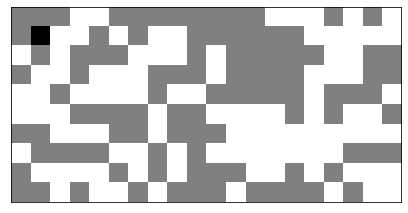

In [8]:
# Define constants that will be used in simulation
H = 10
W = 20
N_ROBOTS = 16
P_DIRTY = 0.5
TIME_LIMIT = 160
actual_time = 0

# Create model with constants
model = CleaningModel(H, W, N_ROBOTS, P_DIRTY)

# Run simulation under time limit or until fully cleaned
while actual_time < TIME_LIMIT and model.num_dirty > model.num_cleaned:
    model.step()
    actual_time += 1

# Collect grids from simulation and plot them
all_grid = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.binary)
def animate(i):
    patch.set_data(all_grid.iloc[i][0])
anim = animation.FuncAnimation(fig, animate, frames = actual_time)


In [9]:
print("Report")
if model.num_dirty == model.num_cleaned:
    print("Room fully cleaned in: %i iterations" %(actual_time))
else:
    print("Room partially cleaned. %i vacuumed spots with %i dirty spots left." %(model.num_cleaned, model.num_dirty - model.num_cleaned))
print("Percentage of clean spots after simulation: %2.2f" %(((model.grid.height * model.grid.width) - (model.num_dirty - model.num_cleaned))/(model.grid.height * model.grid.width)))
print("More than one robot tried to clean the same spot %i times." %(model.num_collisions))
print("Robots crashed the wall %i times." %(model.num_invalid_moves))
print("%i Robots moved a total of %i times." %(model.num_robots, model.num_total_moves))

anim

Report
Room partially cleaned. 72 vacuumed spots with 28 dirty spots left.
Percentage of clean spots after simulation: 0.86
More than one robot tried to clean the same spot 220 times.
Robots crashed the wall 351 times.
16 Robots moved a total of 2137 times.
